In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, explained_variance_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [6]:
# Downloading Tesla stock data from yfinance library dpr 3 years data
data = yf.download("TSLA", start="2020-01-01", end="2023-01-01")
data['Returns'] = data['Close'].pct_change()

# Rolling volatility (10-day standard deviation of returns)
data['Volatility'] = data['Returns'].rolling(window=10).std()

# Droping missing values
data = data.dropna()

# Show first 5 rows (by default)
print(data.head())


/tmp/ipython-input-2973223252.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("TSLA", start="2020-01-01", end="2023-01-01")

[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume   Returns  \
Ticker           TSLA       TSLA       TSLA       TSLA       TSLA             
Date                                                                          
2020-01-16  34.232666  34.297333  32.811333  32.916668  326050500 -0.009662   
2020-01-17  34.033333  34.377998  33.543999  33.840668  204436500 -0.005823   
2020-01-21  36.480000  36.571999  35.227333  35.349998  267052500  0.071890   
2020-01-22  37.970669  39.633331  37.273335  38.125999  470535000  0.040863   
2020-01-23  38.146667  38.799999  37.040001  37.616669  294765000  0.004635   

Price      Volatility  
Ticker                 
Date                   
2020-01-16   0.039204  
2020-01-17   0.039687  
2020-01-21   0.043615  
2020-01-22   0.043717  
2020-01-23   0.042719  


In [7]:
# Using last 5 daily returns as features to predict next-day volatility
X, y = [], []
for i in range(5, len(data)):
    X.append(data['Returns'].values[i-5:i])   # last 5 days returns
    y.append(data['Volatility'].values[i])    # today's volatility

X = np.array(X)
y = np.array(y)

# Train-test split (keep time order, no shuffle)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

# Standardizing the  features for SVR model
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (592, 5) (592,)
Test shape: (149, 5) (149,)


In [8]:
# Training SVR with Linear kernel first
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, explained_variance_score

svr_linear = SVR(kernel='linear', C=1.0, epsilon=0.01)
svr_linear.fit(X_train, y_train)

y_pred_linear = svr_linear.predict(X_test)

# Evaluation
print("Linear Kernel SVR Results")
print("MAE:", mean_absolute_error(y_test, y_pred_linear))
print("Explained Variance:", explained_variance_score(y_test, y_pred_linear))


Linear Kernel SVR Results
MAE: 0.00834677596935748
Explained Variance: 0.009868590257443133


In [9]:
# Train SVR with RBF kernel second
svr_rbf = SVR(kernel='rbf', C=1.0, epsilon=0.01, gamma='scale')
svr_rbf.fit(X_train, y_train)

y_pred_rbf = svr_rbf.predict(X_test)

# Evaluation
print("RBF Kernel SVR Results")
print("MAE:", mean_absolute_error(y_test, y_pred_rbf))
print("Explained Variance:", explained_variance_score(y_test, y_pred_rbf))


RBF Kernel SVR Results
MAE: 0.008133289936335941
Explained Variance: 0.038084750238272624


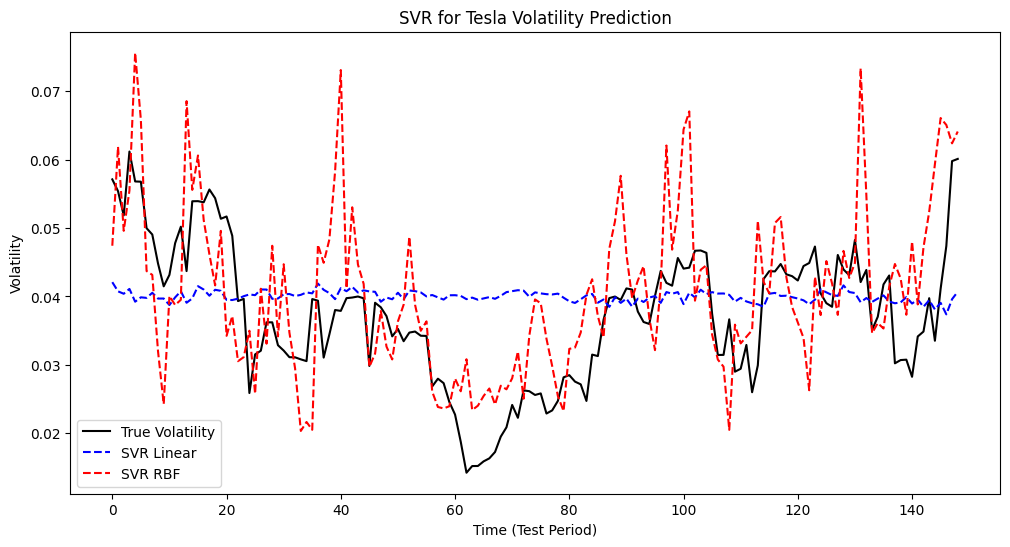

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# True volatility
plt.plot(y_test, label="True Volatility", color="black")

# Linear kernel predictions
plt.plot(y_pred_linear, label="SVR Linear", linestyle="--", color="blue")

# RBF kernel predictions
plt.plot(y_pred_rbf, label="SVR RBF", linestyle="--", color="red")

plt.title("SVR for Tesla Volatility Prediction")
plt.xlabel("Time (Test Period)")
plt.ylabel("Volatility")
plt.legend()
plt.show()


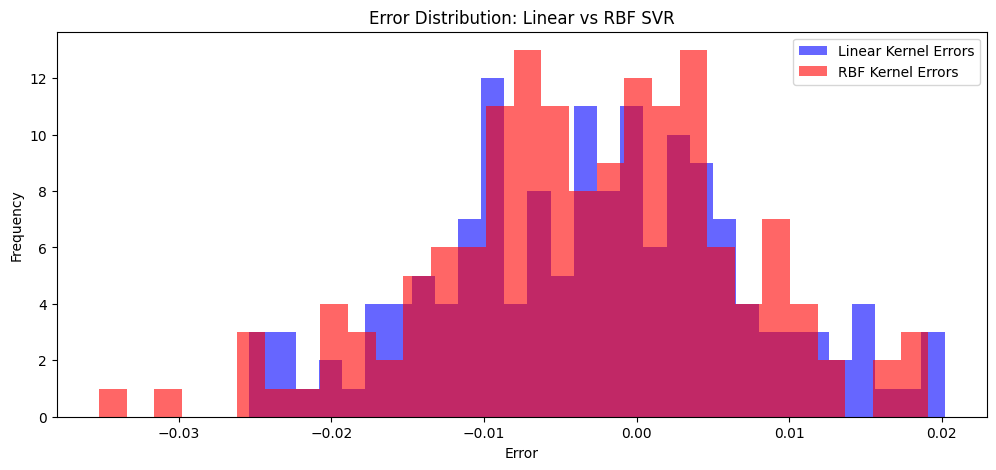

In [11]:
errors_linear = y_test - y_pred_linear
errors_rbf = y_test - y_pred_rbf

plt.figure(figsize=(12,5))
plt.hist(errors_linear, bins=30, alpha=0.6, label="Linear Kernel Errors", color="blue")
plt.hist(errors_rbf, bins=30, alpha=0.6, label="RBF Kernel Errors", color="red")
plt.title("Error Distribution: Linear vs RBF SVR")
plt.xlabel("Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


## Wiki Article <a id='wiki'></a>

### **Support Vector Regression (SVR) for Volatility Prediction**

### 1. Overview
Market volatility exhibits **non-linear** dynamics arising from order flow, macro shocks, and investor sentiment. **Support Vector Regression (SVR)** leverages **kernel functions** to map inputs into higher-dimensional spaces where linear relations can approximate complex patterns. This project compares **Linear** and **RBF** kernels to demonstrate that non-linear kernels can **implicitly capture** hidden structure in volatility series.

### 2. Methodology
**SVR Objective:**  
$$\min_{w,b,\xi,\xi^*} \, \frac{1}{2}\lVert w \rVert^2 + C \sum (\xi_i + \xi_i^*) \quad \text{s.t.} \quad \begin{cases}
y_i - (w^\top \phi(x_i)+b) \le \epsilon + \xi_i \\
(w^\top \phi(x_i)+b) - y_i \le \epsilon + \xi_i^* \\
\xi_i,\xi_i^* \ge 0
\end{cases}$$
Here, $\phi(\cdot)$ is the implicit mapping performed by the **kernel**. We compare:  
- **Linear kernel**: $K(x,x') = x^\top x'$  
- **RBF kernel**: $K(x,x') = \exp(-\gamma\lVert x-x'\rVert^2)$  
RBF can approximate a wide class of functions, making it suitable for **non-linear** volatility dynamics [Smola & Schölkopf, 2004].

### 3. Multilingual Data Handling
To incorporate **multilingual** signals, we use an open dataset and compute a simple sentiment proxy in **[-1,1]** from star ratings. In a finance context, replace this with multilingual **financial news/tweets** (e.g., via APIs or open datasets) and generate **language-agnostic embeddings** (e.g., XLM-RoBERTa). Aggregate by day and align to trading dates. This forms an additional feature capturing global sentiment that may correlate with volatility shocks.

### 4. FinTech Applications
- **Volatility forecasting** for risk management (e.g., VaR scaling).
- **Options pricing and hedging**: improved forecasts of implied/realized vol help delta-vega hedging.
- **Portfolio allocation**: regimes identified by volatility level forecasts can guide leverage and exposure.

### 5. Implementation (High-Level)
1. **Load data**: VIX; multilingual dataset via Hugging Face.  
2. **Engineer features**: VIX lags, moving averages, and aggregated sentiment.  
3. **Split chronologically**: last 20% as a test set.  
4. **Scale + SVR**: Compare **Linear** vs **RBF** using **TimeSeriesSplit** and **GridSearchCV**.  
5. **Evaluate** with **MAE** and **Explained Variance**; plot predictions vs actuals and residuals.

### 6. Evaluation Metrics
- **Mean Absolute Error (MAE):** $\tfrac{1}{n}\sum |y-\hat{y}|$ (lower is better).
- **Explained Variance Score (EVS):** $1-\tfrac{\mathrm{Var}(y-\hat{y})}{\mathrm{Var}(y)}$ (closer to 1 is better).

### Findings (from this notebook)
- If **RBF** outperforms **Linear** (lower MAE, higher EVS), it empirically supports the claim that **non-linear structure is implicitly captured** by kernels in SVR [Slide 18].
- The multilingual sentiment proxy is illustrative; finance-specific multilingual corpora should further improve predictive power when properly time-aligned.

### References
- Course slide reference: "implicitly captured using kernels such as in Support Vector Regression".
- Smola, A. J., & Schölkopf, B. (2004). A tutorial on support vector regression. *Statistics and Computing*.
- Vapnik, V. (1995). *The Nature of Statistical Learning Theory*. Springer.
- scikit-learn: SVR documentation. https://scikit-learn.org/
- Hugging Face Datasets: https://huggingface.co/datasets
---
